<a href="https://colab.research.google.com/github/NILodio/EACD-MONOGRAFIA/blob/master/01_MONOGRAFIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Key Word)

Hello, I hope you are having a great day.

In this notebook, I will try the process of implementing CNN with Keras in order to classify images a find a key word.
1. Firstly, we'll import usefull packages.
1. Then, we'll load the data, before visualize and preprocess it.
1. We'll try a simple CNN model and then we will evaluate its performances.
1. We will then use pre trained model to address this challenge aswell.

# Import Packages

In [104]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import uuid
import json
import tensorflow as tf

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [105]:
from local.lib import load_data as dt
dic = {'Formato_1': 1, 'Formato_2': 2, 'Formato_3': 3}

In [106]:
Data = dt.create_and_read_metadata(images_path=  'local/data/imgs' ,medata_path= 'local/data',split_value= 0.7 , labels_dic=dic)

In [107]:
Train , Test = (Data[Data['split'] == 'train'] , Data[Data['split'] != 'train'] )

# Let's explore the dataset

1. How many training and testing examples do we have ?
2. What is the size of the images ?
3. What is the proportion of each observed category ?

In [108]:


n_train = Train.shape[0]
n_test = Test.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))


Number of training examples: 261
Number of testing examples: 134


<AxesSubplot:>

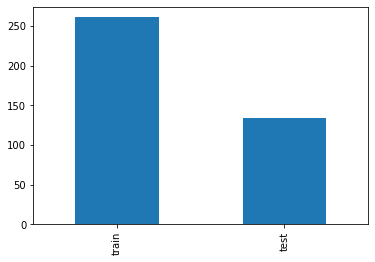

In [109]:
Data['split'].value_counts().plot(kind='bar')

In [110]:
Train.head(5)

,names,xmin,xmax,ymin,ymax,split,label
0,09-22-2020-14.53.24(1).jpg,0.137416,0.279979,0.394874,0.420505,train,1
1,09-22-2020-14.53.24(10).jpg,0.153446,0.291938,0.391390,0.415141,train,1
2,09-22-2020-14.53.24(100).jpg,0.142093,0.296076,0.380736,0.406633,train,1
4,09-22-2020-14.53.24(102).jpg,0.137374,0.289899,0.372496,0.402928,train,1
6,09-22-2020-14.53.24(104).jpg,0.128908,0.293472,0.375156,0.408504,train,1


### Let's explore the dataset with label == 1


In [111]:
Train[Train['label'] == 1].describe()

,xmin,xmax,ymin,ymax,label
count,136.000000,136.000000,136.000000,136.000000,136.0
mean,0.139390,0.287146,0.386539,0.413561,1.0
std,0.055271,0.055381,0.024567,0.024105,0.0
min,0.000688,0.120358,0.276580,0.301790,1.0
25%,0.133376,0.278218,0.379508,0.405804,1.0
50%,0.139593,0.286585,0.385909,0.413408,1.0
75%,0.147026,0.295635,0.393429,0.420696,1.0
max,0.708696,0.863478,0.594419,0.618430,1.0


<AxesSubplot:>

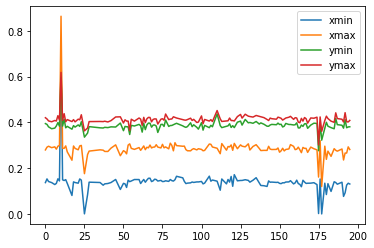

In [112]:
Train[['xmin','xmax','ymin','ymax']][Train['label'] == 1].plot()

In [113]:
from local.lib import F_Plots as MyPlot

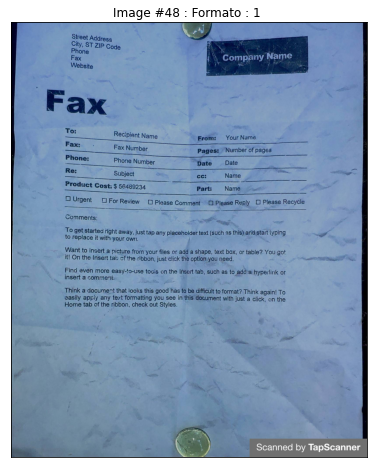

In [114]:
MyPlot.display_random_image(Train,1)

In [88]:


img = Image.open(os.path.join('local\\data\\imgs',Train['names'][0]))
image_n = np.array(img)
len_x , len_y , _ =  image_n.shape
len_x

2497

#### Save Data Xml in a List

In [58]:
os.path.join(image_path,images.iloc[index][0])

'local/data/imgs\\09-22-2020-14.53.24(68).jpg'

In [4]:
Data_list=[]
for file in os.listdir("local/imgs"):
    if file.endswith(".xml"):
        Data_list.append(read_content(os.path.join("local/imgs" , file)))


<AxesSubplot:>

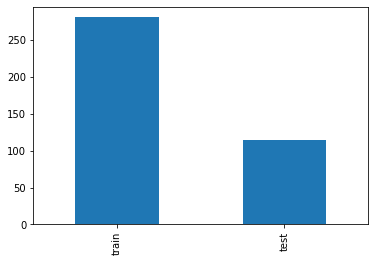

In [20]:
df['split'].value_counts().plot(kind='bar')

### Split Data

In [1]:
def build_sources_from_metadata(metadata, data_dir, mode='train', exclude_labels=None):
    
    if exclude_labels is None:
        exclude_labels = set()
    if isinstance(exclude_labels, (list, tuple)):
        exclude_labels = set(exclude_labels)

    df = metadata.copy()
    df = df[df['split'] == mode]
    df['filepath'] = df['img'].apply(lambda x: os.path.join(data_dir, x))
    include_mask = df['label'].apply(lambda x: x not in exclude_labels)
    df = df[include_mask]

    sources = list(zip(df['filepath'],zip(df["xmin"],df["xmax"],df["ymin"],df["ymax"]),df['label']))
    return sources


In [2]:
train_sources = build_sources_from_metadata(metadata, 'local/imgs')
test_sources = build_sources_from_metadata(metadata, 'local/imgs',mode='test')

NameError: name 'metadata' is not defined

In [34]:
print(type(train_sources))
print(train_sources[0:2])

<class 'list'>
[('local/imgs\\09-22-2020-14.53.24(1).jpg', (0.13741636644364386, 0.2799794132784354, 0.394873848618342, 0.42050460552663194), 1), ('local/imgs\\09-22-2020-14.53.24(10).jpg', (0.15344603381014305, 0.2919375812743823, 0.3913904007916873, 0.4151410192973775), 1)]


In [ ]:
def imshow_batch_of_three(batch, num_images = 1, show_label=True ):
    
    label_batch = batch[1].numpy()
    image_batch = batch[0].numpy()
    fig, axarr = plt.subplots(1, num_images, figsize=(15, 5), sharey=True)
    
    for i in range(num_images):
        img = image_batch[i, ...]
        axarr[i].imshow(img)
        if show_label:
            axarr[i].set(xlabel='label = {}'.format(label_batch[i]))

## TensorFlow DataSet

In [51]:
def preprocess_image(image):
    image = tf.image.resize(image, size=(224, 224))
    image = image / 255.0
    return image

def augment_image(image):
    return image

def make_dataset(sources, training=False, batch_size=1,
    num_epochs=1, num_parallel_calls=1, shuffle_buffer_size=None):
    
    """
    Returns an operation to iterate over the dataset specified in sources

    Args:
        sources (list): A list of (filepath, label_id) pairs.
        training (bool): whether to apply certain processing steps
            defined only in training mode (e.g. shuffle).
        batch_size (int): number of elements the resulting tensor
            should have.
        num_epochs (int): Number of epochs to repeat the dataset.
        num_parallel_calls (int): Number of parallel calls to use in
            map operations.
        shuffle_buffer_size (int): Number of elements from this dataset
            from which the new dataset will sample.

    Returns:
        A tf.data.Dataset object. It will return a tuple images of shape
        [N, H, W, CH] and labels shape [N, 1].
    """
    def load(row):
        filepath = row['image']
        img = tf.io.read_file(filepath)
        img = tf.io.decode_jpeg(img)
        return img, row['label']

    if shuffle_buffer_size is None:
        shuffle_buffer_size = batch_size*4

    images, Bounding_Box , labels = zip(*sources)
    
    ds = tf.data.Dataset.from_tensor_slices({
        'image': list(images),'bounding_box' : list(Bounding_Box), 'label': list(labels)}) 
 #line from the link. As with most code, if you remove an arbitrary line, expectin
    if training:
        ds = ds.shuffle(shuffle_buffer_size)
    
    ds = ds.map(load, num_parallel_calls=num_parallel_calls)
    ds = ds.map(lambda x,y: (preprocess_image(x), y))
    
    if training:
        ds = ds.map(lambda x,y: (augment_image(x), y))
        
    ds = ds.repeat(count=num_epochs)
    ds = ds.batch(batch_size=batch_size)
    ds = ds.prefetch(1)

    return ds

In [52]:
dataset = make_dataset(train_sources, training=False,
    batch_size=3, num_epochs=1,
    num_parallel_calls=3)

In [3]:
from local.data import load_data

ImportError: cannot import name 'load_data' from 'local.data' (unknown location)

In [4]:
%run local/data/lib/limyfile.py

Exception: File `'local/data/lib/limyfile.py'` not found.